<a href="https://colab.research.google.com/github/FelipeAugus/dio-baires-dev--machine-learning-training-ipynb/blob/main/06-processamento-de-imagens-com-ml/sistema-de-recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtenção e preparo dos dados

## Opção 1: Fonte original + preprocesssamento

In [86]:
!curl -L -s -o fashion-product-images-small.zip https://www.kaggle.com/api/v1/datasets/download/paramaggarwal/fashion-product-images-small
!rm -rf fashion-product-images-small
!unzip -q fashion-product-images-small.zip -d fashion-product-images-small
!rm -rf fashion-product-images-small.zip

!wget -q -O img.jpg https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg
!wget -q -O img2.jpg https://m.media-amazon.com/images/I/81zLiNdxCJL._AC_SY575_.jpg

In [2]:
import os
import pandas as pd

from shutil import move

In [3]:
df = pd.read_csv('fashion-product-images-small/styles.csv', usecols=['id','masterCategory','subCategory','articleType']).reset_index()

# Unifica os produtos que são do mesmo tipo. Pega 10 tipos com mais dados e 100 coisas de cada
df['combined_category'] = df['masterCategory'] + '__' + df['subCategory'] + '__' + df['articleType']
df['combined_category'] = df['combined_category'].apply(lambda x: x.lower().replace(' ', '_'))

top_categories = df['combined_category'].value_counts().nlargest(10).index.tolist()
df_filtered = df[df['combined_category'].isin(top_categories)]

df_simplificado = df_filtered.groupby('combined_category').head(100).reset_index(drop=True)

df_simplificado = df_simplificado[['id', 'combined_category']]
df_simplificado['combined_category'].value_counts()

,count
combined_category,
apparel__topwear__shirts,100
accessories__watches__watches,100
apparel__topwear__tshirts,100
footwear__shoes__casual_shoes,100
accessories__bags__handbags,100
apparel__topwear__tops,100
apparel__topwear__kurtas,100
footwear__shoes__sports_shoes,100
footwear__shoes__heels,100


In [4]:
import os
for category in df_simplificado['combined_category'].unique():
    os.makedirs(os.path.join('database/images', category), exist_ok=True)

In [5]:
co = 0
for _, row in df_simplificado.iterrows():
    id = str(row['id'])+'.jpg'
    category = row['combined_category']

    path_from = os.path.join('fashion-product-images-small/images', id)
    path_to = os.path.join('database/images', category, id)
    try:
        move(path_from, path_to) # shutil
        co += 1
    except FileNotFoundError:
        print(f"Warning: Image file not found at {path_from}. Skipping.")
print('Moved {} images.'.format(co))

Moved 1000 images.


## Opção 2: Dados já trabalhados que estão no meu git :)

In [ ]:
# TODO: Realizar upload dos dados para o git e puxar aqui as coisas já meio pronta

# Modelo 01



In [94]:
!pip install -q faiss-cpu

import os
import torch
import faiss
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Notei que ao tentar aplicar Fine Tuning os resultados do modelo ficaram piores :/
# Mantive o trecho para caso depois queira ajustar hiperparâemtros e ver se mioro isso
FINE_TUNING = False


In [95]:
DATA_DIR = 'database/images'
BATCH_SIZE = 32
EPOCHS = 15
# ----- "Conversão" das Imagens para Tensors -----
# Aqui é definido o fluxo de transformações que cada imagem vai passar para então entrar no fine tunning e depois virar embedding
transform = transforms.Compose([
    transforms.Resize(256),     # Redimensiona a imagem para que o menor lado tenha 256 pixels, mantendo a proporção original.
    transforms.CenterCrop(224), # Corta o centro da imagem para um tamanho de 224x224 pixels. A maioria dos modelos pré-treinados espera imagens de 224x224 como entrada.
    transforms.ToTensor(),      # Converte a imagem (PIL) em um tensor (PyTorch). Isso também escala os valores de pixel de [0, 255] para [0, 1].
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), # Normaliza os canais de cor
])
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

NUM_CLASSES = len(dataset.classes)
print(f"Number of classes found: {NUM_CLASSES}")

# ----- Definição do Modelo para o fine-tuning -----
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# trocando a última camada ou a "Fully Connected layer".
# naturalmente essa camada teria como saida 1000 classes do ImageNet
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
# config para utilizar GPU caso disponivel (acelera d++ o treinamento)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ----- Pequeno treinamento simples -----
if FINE_TUNING:
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss  = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} loss: {total_loss/len(loader):.4f}")

# ----- Extrair embeddings para todo o dataset -----
# A remoção da última camada é por que não queremos classificar as imagens após o treino e sim buscar similaridade
# Dessa forma o retorno da rede será a representação numérica da imagem que o modelo aprendeu nas camadas anteriores.
# Essa representação numérica é o que chamamos de embedding ou vetor de características.
feat_extractor = nn.Sequential(*list(model.children())[:-1])  # tudo menos o fc
feat_extractor.eval() # "Finaliza" o treinamento do modelo, e coloca ele no modo de avaliação

embeddings = []
# Desabilita gradientes, visto que não tá treinando mais
with torch.no_grad():
    # Percorre cada imagem e obtem o embefdding dela
    for img, _ in dataset:
        img = img.unsqueeze(0).to(device)
        feat = feat_extractor(img).squeeze().cpu().numpy()
        embeddings.append(feat)
paths = []
paths = [img_path for img_path, label in dataset.imgs]

emb_matrix = np.stack(embeddings).astype('float32')

# ----- Index FAISS para busca de k-NN -----
index = faiss.IndexFlatL2(emb_matrix.shape[1])
index.add(emb_matrix)

Number of classes found: 10


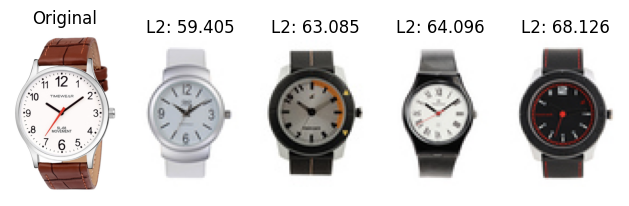

In [96]:
def recomendar(img_query_path, top_k=5):
    # pré-processa a imagem
    img = transform(Image.open(img_query_path)).unsqueeze(0).to(device)
    # obtem o embedding
    with torch.no_grad(): q_emb = feat_extractor(img).squeeze().cpu().numpy().astype('float32')
    # busca k-NN no vetor de embeddings
    dist, idxs = index.search(q_emb.reshape(1, -1), top_k)
    return [(paths[i], float(dist[0][j])) for j,i in enumerate(idxs[0])]

def teste_modelo1(sample_img_path):
    top_k = 4
    resultados = recomendar(sample_img_path, top_k=top_k)

    plt.subplot(1, top_k+1, 1)
    plt.title(f"Original")
    plt.imshow(mpimg.imread(sample_img_path))
    plt.axis('off')
    for i, (caminho, distancia) in enumerate(resultados):
        plt.subplot(1, top_k+1, i+2)
        plt.title(f"L2: {distancia:.3f}")
        plt.imshow(mpimg.imread(caminho))
        plt.axis('off')

    plt.tight_layout() # Adjust layout to prevent overlapping
    plt.show()

teste_modelo1('img.jpg')

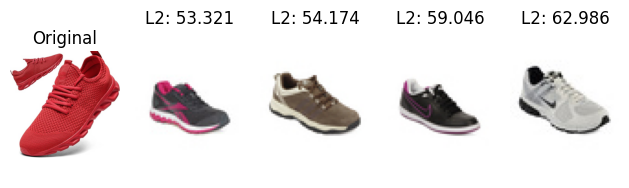

In [97]:
teste_modelo1('img2.jpg')

# Modelo 02.
- Adaptado de 'https://colab.research.google.com/github/sparsh-ai/rec-tutorials/blob/master/_notebooks/2021-04-27-image-similarity-recommendations.ipynb#scrollTo=WQ9BN_MsiwSy'

In [46]:
!pip install -q annoy

import os
import glob
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.image as mpimg

from annoy import AnnoyIndex
from scipy import spatial
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from PIL import Image
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [99]:
img_paths = []
for path in Path('database/images').rglob('*.jpg'): img_paths.append(path)
np.random.shuffle(img_paths)

def load_img(path): # Faz mais ou menos o que é feito no transforms.Compose do modelo 1
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)      # Decodifica a imagem em um tensor de 3 cores
  img = tf.image.resize_with_pad(img, 224, 224) # Corta o centro da imagem para um tamanho de 224x224 pixels
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

# Baixa um modelo pre treinado
module = hub.load("https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1")

imgvec_path = 'img_vectors_2/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

# Percorre cada uma das imgs e extrai os embeddings
for filename in tqdm(img_paths[:1000]):
    img = load_img(str(filename))
    features = module(img) # gera embedding
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npy"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.save(out_path_file, feature_set) # salva arquivo

# le o arquivo de classes e gera um novo csv so com as linhas validas
styles = pd.read_csv('fashion-product-images-small/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
styles.to_csv('styles.csv', index=False)

def match_id(fname): return styles.index[styles.id==fname].values[0]


# ----- Index Annoy -----

#Cria um map index to file, to embedding e to product. Alem disso adiciona no index as coisas
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

allfiles = glob.glob('/content/img_vectors_2/*.npy')

dims = 1000   # Tamanho do embedding, tem que ser o tamanho que a rede retorna
index_annoy = AnnoyIndex(dims, metric='angular')
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.load(fname) # Carrega o embedding gerado anteriormente
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try: file_index_to_product_id[findex] = match_id(file_name)
  except IndexError: pass
  index_annoy.add_item(findex, file_vector)

trees = 10000 # Define a quantidade de arvore de busca que serão construidas para o Index Annoy (Quanto maior melhor, mas mais custoso)
index_annoy.build(trees) # constrói as árvores internas do índice Annoy. Este é um passo de "treinamento" para otimizar a estrutura do índice para buscas rápidas.

100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'fashion-product-images-small/styles.csv'

/tmp/ipython-input-4198385843.py:37: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


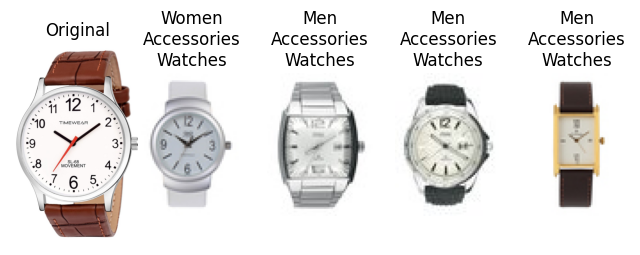

In [104]:
path_dict = {}
for path in Path('database/images').rglob('*.jpg'): path_dict[path.name] = path

def recomendar2(img_query_path, top_k=5):
    # pré-processa a imagem
    test_vec = np.squeeze(module(load_img(img_query_path)))
    basewidth = 224
    img = Image.open(img_query_path)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth, hsize))
    img = transform(Image.open(img_query_path)).unsqueeze(0).to(device)
    # obtem o embedding
    with torch.no_grad(): q_emb = feat_extractor(img).squeeze().cpu().numpy().astype('float32')
    # busca k-NN no vetor de embeddings
    dist, idxs = index.search(q_emb.reshape(1, -1), top_k)
    return index_annoy.get_nns_by_vector(test_vec, n=topK)

def teste_modelo2(sample_img_path):
    topK = 4
    resultados = recomendar2(sample_img_path, topK)

    plt.figure(figsize=(8, 5))
    plt.subplot(1, topK, 1)
    plt.title('Original')
    plt.imshow(mpimg.imread(sample_img_path))
    plt.axis('off')
    for i in range(topK):
        x = file_index_to_file_name[resultados[i]]
        x = path_dict[x+'.jpg']
        y = file_index_to_product_id[resultados[i]]
        title = '\n'.join([str(j) for j in list(styles.loc[y].values[1:4])])
        plt.subplot(1, topK+1, i+2)
        plt.title(title)
        plt.imshow(mpimg.imread(x))
        plt.axis('off')
    plt.tight_layout()

teste_modelo2('img.jpg')

/tmp/ipython-input-4198385843.py:37: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


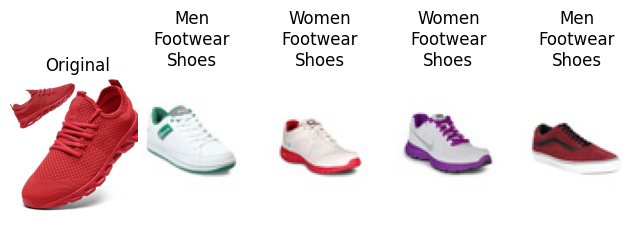

In [105]:

teste_modelo2('img2.jpg')